In [1]:
import os
import glob 
import json
import pandas as pd
import numpy as np
import nibabel as nib
from natsort import natsorted
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.file_reader import onsets_to_dm
from nltools.mask import expand_mask
from nltools.stats import align, regress, zscore

import matplotlib.pyplot as plt

In [2]:
# I/O
all_data = []
target_run, train_run = 1, 7
sub_list = ["01", "02", "03", "04", "06"] # , "10", "14", "15", "16", "17", "18", "19", "20"
event_file = "/home/exp-psy/Desktop/study_face_tracks/derivatives/reference_face-tracks/studyf_run-01_face-orientation.csv"
deriv_dir = "/home/exp-psy/Desktop/study_face_tracks/derivatives/"
out_dir = os.path.join(deriv_dir, "hyperalignment")
print("output folder:\t", out_dir)

output folder:	 /home/exp-psy/Desktop/study_face_tracks/derivatives/hyperalignment


In [3]:
# store output
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

In [43]:
# nuis. regressors to keep
conf_keep_list = [
    "trans_x", "trans_y", "trans_z", 
    "rot_x", "rot_y", "rot_z"
]

# additional nuis. regressors
conf_add_list = [
    "csf", "white_matter", 
    "a_comp_cor_00", "a_comp_cor_01", 
    "a_comp_cor_02", "a_comp_cor_03", 
    "a_comp_cor_04"
]

In [5]:
lut_df = pd.read_csv("/home/exp-psy/Desktop/study_face_tracks/derivatives/fmriprep_mni/desc-aparcaseg_dseg.tsv", sep="\t")
lut_df

,index,name,color
0,0,Unknown,#000000
1,1,Left-Cerebral-Exterior,#4682b4
2,2,Left-Cerebral-White-Matter,#f5f5f5
3,3,Left-Cerebral-Cortex,#cd3e4e
4,4,Left-Lateral-Ventricle,#781286
...,...,...,...
1369,14171,wm_rh_S_suborbital,#15143c
1370,14172,wm_rh_S_subparietal,#653c3c
1371,14173,wm_rh_S_temporal_inf,#15b4b4
1372,14174,wm_rh_S_temporal_sup,#dfdc3c


## data descr. volumes per run:
- run-1: 451
- run-2: 441
- run-3: 438
- run-4: 488
- run-5: 462 
- run-6: 439
- run-7: 542
- run-8: 338

In [6]:
if target_run == 1:
    train_volumes = 451
elif target_run == 2:
    train_volumes = 441
elif target_run == 3:
    train_volumes = 438
elif target_run == 4:
    train_volumes = 488
elif target_run == 5:
    train_volumes = 462
elif target_run == 6:
    train_volumes = 439
elif target_run == 7:
    train_volumes = 542
elif target_run == 8:
    train_volumes = 338

In [7]:
def slicer(in_path, train_volumes):
    img = nib.load(in_path)
    img_data = img.get_fdata()
    sliced_data = img_data[..., :train_volumes]
    print("shape of the training data:\t", sliced_data.shape)
    return nib.Nifti1Image(sliced_data, affine=img.affine, header=img.header)

## load training data

In [8]:
for sub in sub_list:
    # paths
    aparc_fpath = os.path.join(
        "/home", 
        "exp-psy", 
        "Desktop", 
        "study_face_tracks", 
        "derivatives", 
        "fmriprep_mni",
        f"sub-{sub}", 
        "ses-movie", 
        "func", 
        f"sub-{sub}_ses-movie_task-movie_run-{train_run}_space-MNI152NLin2009cAsym_res-2_desc-aparcaseg_dseg.nii.gz"
    )
    print(f"extracting data from subject: {sub}")
    affine = nib.load(aparc_fpath).affine 
    aparc_data = nib.load(aparc_fpath).get_fdata()
    
    # create mask
    matches = lut_df[lut_df['name'] == 'ctx-lh-frontalpole']
    left_index = matches['index'].values[0]
    matches = lut_df[lut_df['name'] == 'ctx-rh-frontalpole']
    right_index = matches['index'].values[0]

    fusiform_mask = np.zeros_like(aparc_data, dtype=bool)
    fusiform_mask[aparc_data == float(left_index)] = True
    fusiform_mask[aparc_data == float(right_index)] = True

    # turn into nifti
    roi_mask = nib.nifti1.Nifti1Image(fusiform_mask*1.0, affine=affine)
        
    func_f = os.path.join(
        "/home", 
        "exp-psy", 
        "Desktop", 
        "study_face_tracks", 
        "derivatives", 
        "fmriprep_mni",
        f"sub-{sub}", 
        "ses-movie", 
        "func", 
        f"sub-{sub}_ses-movie_task-movie_run-{train_run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
        )
    data = Brain_Data(slicer(func_f, train_volumes), mask=roi_mask)
    # data = Brain_Data(func_f, mask=roi_mask)
    all_data.append(data)

extracting data from subject: 01
shape of the training data:	 (97, 115, 97, 451)
extracting data from subject: 02
shape of the training data:	 (97, 115, 97, 451)
extracting data from subject: 03
shape of the training data:	 (97, 115, 97, 451)
extracting data from subject: 04
shape of the training data:	 (97, 115, 97, 451)
extracting data from subject: 06
shape of the training data:	 (97, 115, 97, 451)


## hyperalignment

In [10]:
hyperalign = align(all_data[:4], method="procrustes")
hyperalign.keys()

dict_keys(['transformed', 'common_model', 'transformation_matrix', 'disparity', 'scale', 'isc'])

Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.38')

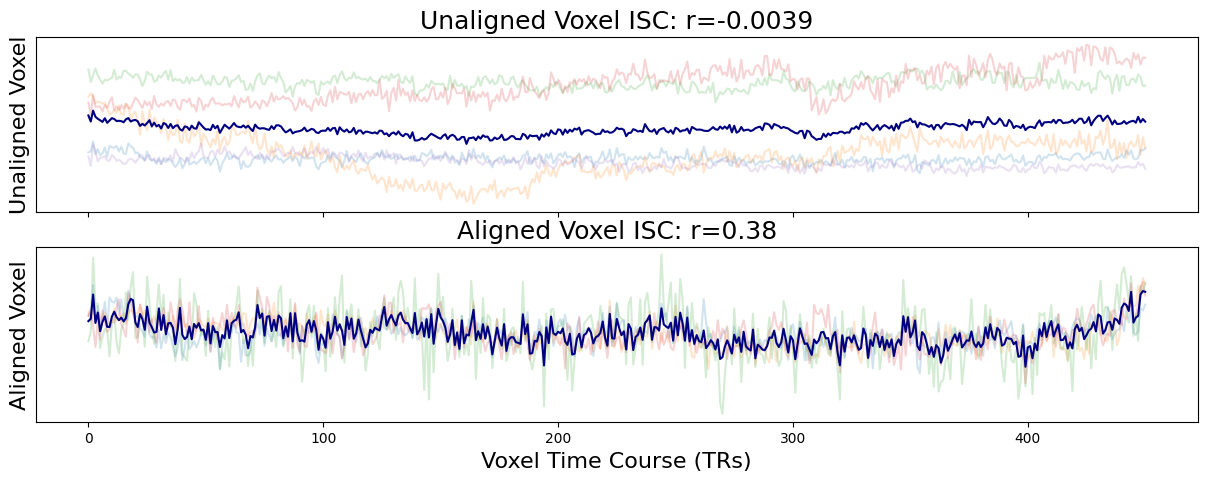

In [11]:
voxel_index = 0

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in all_data]).T
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)

new_data = all_data[-1]

new_data[0].plot()

aligned_sub_hyperalignment = new_data.align(hyperalign['common_model'], method='procrustes')

aligned_sub_hyperalignment['transformed'][0].plot()

## GLM Analysis (LS-S)

In [12]:
sub = "01"

In [13]:
func_f = os.path.join(
    "/home", 
    "exp-psy", 
    "Desktop", 
    "study_face_tracks", 
    "derivatives", 
    "fmriprep_mni",
    f"sub-{sub}", 
    "ses-movie", 
    "func", 
    f"sub-{sub}_ses-movie_task-movie_run-{target_run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
    )

In [14]:
aparc_fpath = os.path.join(
    "/home", 
    "exp-psy", 
    "Desktop", 
    "study_face_tracks", 
    "derivatives", 
    "fmriprep_mni",
    f"sub-{sub}", 
    "ses-movie", 
    "func", 
    f"sub-{sub}_ses-movie_task-movie_run-{target_run}_space-MNI152NLin2009cAsym_res-2_desc-aparcaseg_dseg.nii.gz"
)
print(f"extracting data from subject: {sub}")

affine = nib.load(aparc_fpath).affine 
aparc_data = nib.load(aparc_fpath).get_fdata()

# create mask
matches = lut_df[lut_df['name'] == 'ctx-lh-frontalpole']
left_index = matches['index'].values[0]
matches = lut_df[lut_df['name'] == 'ctx-rh-frontalpole']
right_index = matches['index'].values[0]

fusiform_mask = np.zeros_like(aparc_data, dtype=bool)
fusiform_mask[aparc_data == float(left_index)] = True
fusiform_mask[aparc_data == float(right_index)] = True

# turn into nifti
roi_mask = nib.nifti1.Nifti1Image(fusiform_mask*1.0, affine=affine)

extracting data from subject: 01


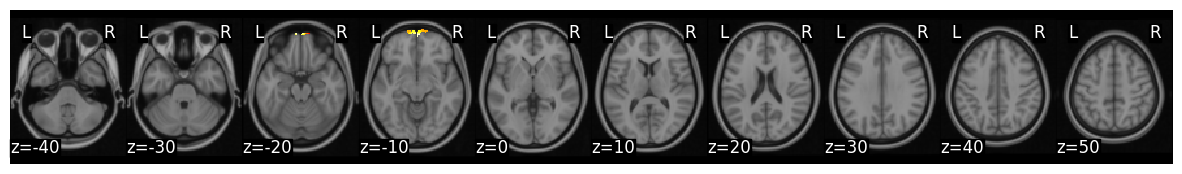

In [31]:
target_data = Brain_Data(func_f, mask=roi_mask)
target_data[1].plot()

In [32]:
print("volumes available:\t", len(align_data))

volumes available:	 451


In [33]:
aligned_sub_hyperalignment = align_data.align(hyperalign["common_model"], method="procrustes")

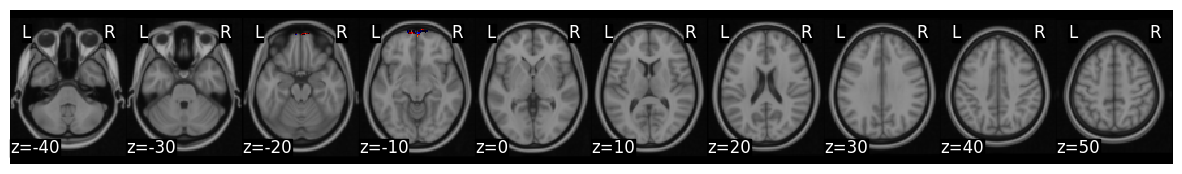

In [35]:
aligned_sub_hyperalignment["transformed"][0].plot()

In [37]:
out_dir_beta = os.path.join(deriv_dir, "hyperalignment", f"sub-{sub}")
print("output folder:\t", out_dir_beta)
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

output folder:	 /home/exp-psy/Desktop/study_face_tracks/derivatives/hyperalignment/sub-01


In [38]:
events = pd.read_csv(event_file, sep=",")
events = events.rename(
    columns={"onset": "Onset", "duration": "Duration", "trial_type": "Stim"}
)
events = events[["Onset", "Duration", "Stim"]]
events = events[events["Stim"].str.count("frontal|right|left") == 1]
events

,Onset,Duration,Stim
0,133,2,frontal-0
1,135,5,right-1
2,162,4,right-2
3,166,2,frontal-1
4,244,10,left-1
...,...,...,...
86,802,5,frontal-32
96,880,3,frontal-34
98,887,5,frontal-35
99,892,3,right-29


In [39]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

In [44]:
conf_file = f"/home/exp-psy/Desktop/study_face_tracks/derivatives/fmriprep_native/sub-{sub}/ses-movie/func/sub-{sub}_ses-movie_task-movie_run-{target_run}_desc-confounds_timeseries.tsv"
confounds = pd.read_csv(conf_file, sep="\t")[conf_keep_list]
confounds.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,0.024521,-0.045345,0.103563,-0.001451,0.000544,0.001098
1,0.019140,-0.070998,0.071514,-0.000342,0.000135,0.000287
2,0.010622,-0.036515,0.100095,-0.001123,0.000309,0.000587
3,0.007693,-0.089453,0.046631,-0.000570,0.000431,0.000379
4,0.006940,0.023665,0.067871,-0.001168,0.000155,0.000791


In [45]:
json_file = f"/home/exp-psy/Desktop/study_face_tracks/derivatives/fmriprep_native/sub-{sub}/ses-movie/func/sub-{sub}_ses-movie_task-movie_run-{target_run}_space-T1w_desc-preproc_bold.json"
with open(json_file, "r") as f:
    metadata = json.load(f)
TR = metadata.get('RepetitionTime', None)
print(f"TR: {TR}")

TR: 2.00000061


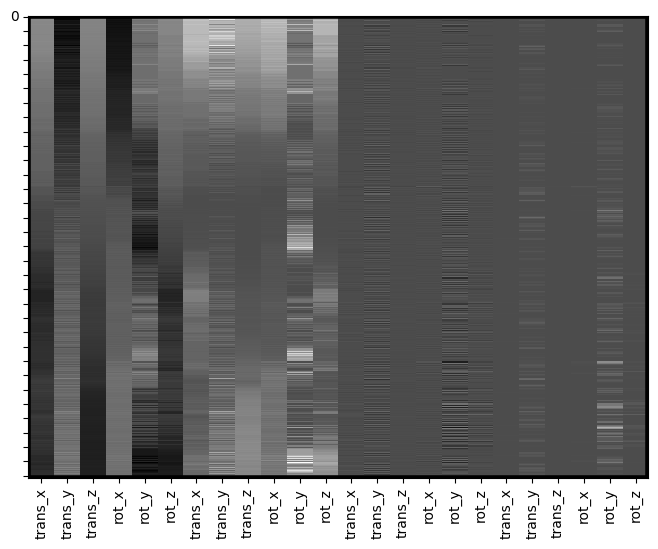

In [46]:
cov_dm = make_motion_covariates(confounds, TR)
cov_dm.heatmap()

In [47]:
confounds_add = pd.read_csv(conf_file, sep="\t")[conf_add_list]
confounds_add.head()

,csf,white_matter,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04
0,436.126500,337.476622,0.043011,-0.043472,0.013747,-0.034376,0.003055
1,433.195484,337.147383,-0.009979,-0.064786,0.024376,-0.027180,-0.043609
2,440.486088,338.088050,-0.058388,0.037546,0.000301,-0.050623,0.002717
3,437.137979,339.262798,0.094601,-0.020738,-0.063570,-0.054669,0.054112
4,438.807934,337.887147,-0.057194,0.005232,-0.016211,-0.010800,0.039982


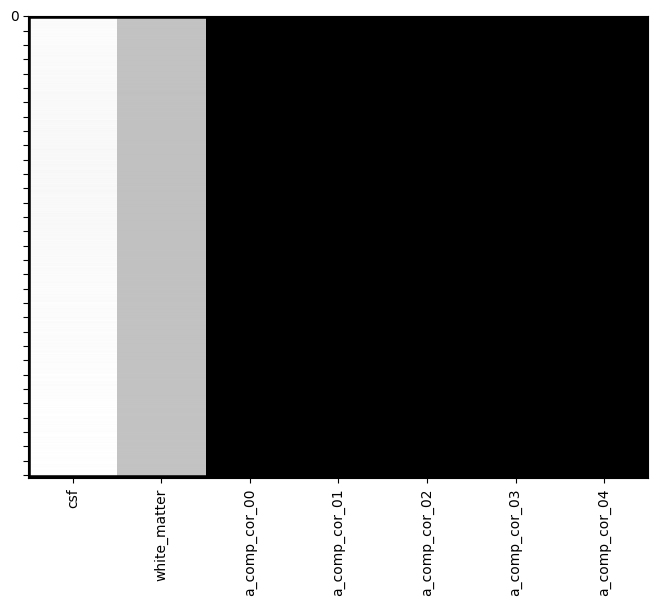

In [48]:
cov_add_dm = Design_Matrix(confounds_add, sampling_freq=1/TR)
cov_add_dm.heatmap()

In [49]:
for i, row in events.iterrows():
    lss_df = events.copy()

    lss_df["Stim"] = lss_df["Stim"].apply(lambda x: x if x == row["Stim"] else "other")
    dm = onsets_to_dm(lss_df, 1/TR, train_volumes)
    dm_conv = dm.convolve()
    dm_conv_filt = dm_conv.add_dct_basis(duration=128)
    dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)

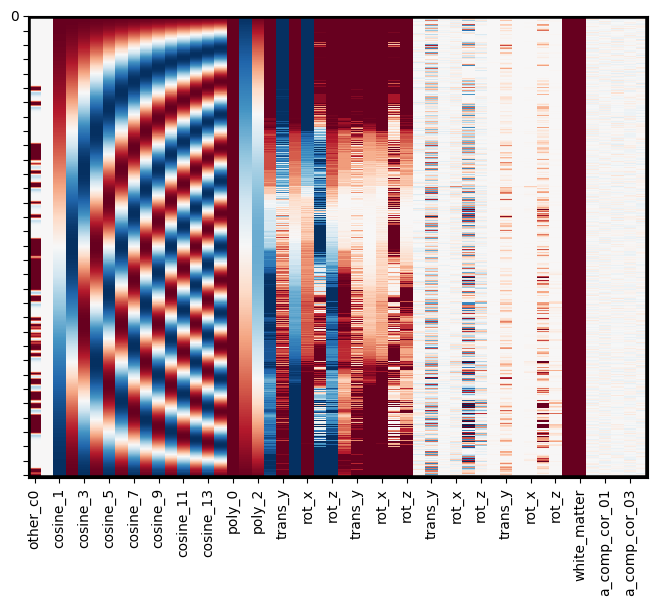

In [50]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, cov_dm, cov_add_dm], axis=1)
dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

In [51]:
aligned_sub_hyperalignment.keys()

dict_keys(['disparity', 'scale', 'transformed', 'common_model', 'transformation_matrix'])

In [52]:
smoothed = aligned_sub_hyperalignment["transformed"].smooth(fwhm=3)
smoothed.X = dm_conv_filt_poly_cov
stats = smoothed.regress()

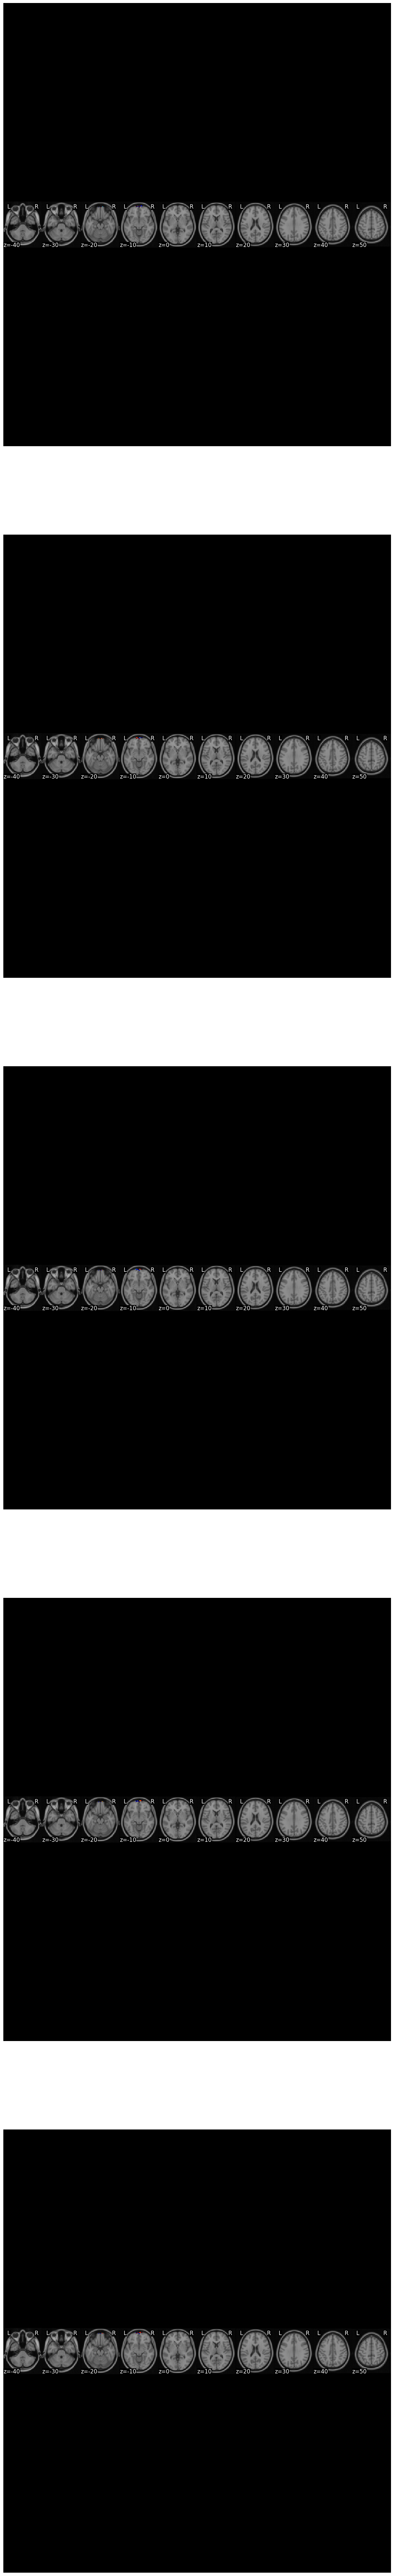

In [56]:
stats["beta"].plot()